In [1]:
#Importing train data

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#to ignore warning when using append instead of concat
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('./data/train.csv')
print(train.shape)
train.head()

(26296946, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [4]:
#importing targets and spilt session id and question number

In [5]:
labels = pd.read_csv('./data/train_labels.csv')
print(labels.shape)

labels['level'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
labels['session_id'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )

labels.head()

(424116, 2)


,session_id,correct,level
0,20090312431273200,1,1
1,20090312433251036,0,1
2,20090312455206810,1,1
3,20090313091715820,0,1
4,20090313571836404,1,1


In [6]:
#import test data

In [7]:
test = pd.read_csv('./data/test.csv')
test.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
0,20090109393214576,0,0,cutscene_click,basic,0,NaN,-413.991405,75.685314,380.0,...,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,0
1,20090109393214576,1,1965,person_click,basic,0,NaN,-105.991405,-63.314686,688.0,...,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
2,20090109393214576,2,3614,person_click,basic,0,NaN,-418.991405,47.685314,375.0,...,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
3,20090109393214576,3,5330,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,...,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
4,20090109393214576,4,6397,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,...,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0


In [8]:
#displaying histogram of all values pre trimming

In [9]:
cols = ['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level', 'page', 
            'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration', 
            'text', 'fqid', 'room_fqid', 'text_fqid', 'fullscreen', 'hq', 'music', 'level_group']

categorical_features = ['event_name', 'name','text', 'fqid', 'room_fqid', 'text_fqid','level_group']
numeric_features = [col for col in train.columns if col not in categorical_features]

In [10]:
level_1 = train[train['level_group'] == '0-4']
level_2 = train[train['level_group'] == '5-12']
level_3 = train[train['level_group'] == '13-22']

In [11]:
slevel_1 = level_1.sample(n=5000)
print(slevel_1.shape)
slevel_2 = level_2.sample(n=5000)
print(slevel_2.shape)
slevel_3 = level_3.sample(n=5000)
print(slevel_3.shape)

(5000, 20)
(5000, 20)
(5000, 20)


In [12]:
strain= slevel_1.append(slevel_2)
strain = strain.append(slevel_3)

C:\Users\mckee\AppData\Local\Temp\ipykernel_12736\1326163993.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strain= slevel_1.append(slevel_2)
C:\Users\mckee\AppData\Local\Temp\ipykernel_12736\1326163993.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strain = strain.append(slevel_3)


In [13]:
label_encoder = preprocessing.LabelEncoder()
for feature in categorical_features:
    strain[feature] = label_encoder.fit_transform(strain[feature])
    test[feature]=label_encoder.fit_transform(test[feature])

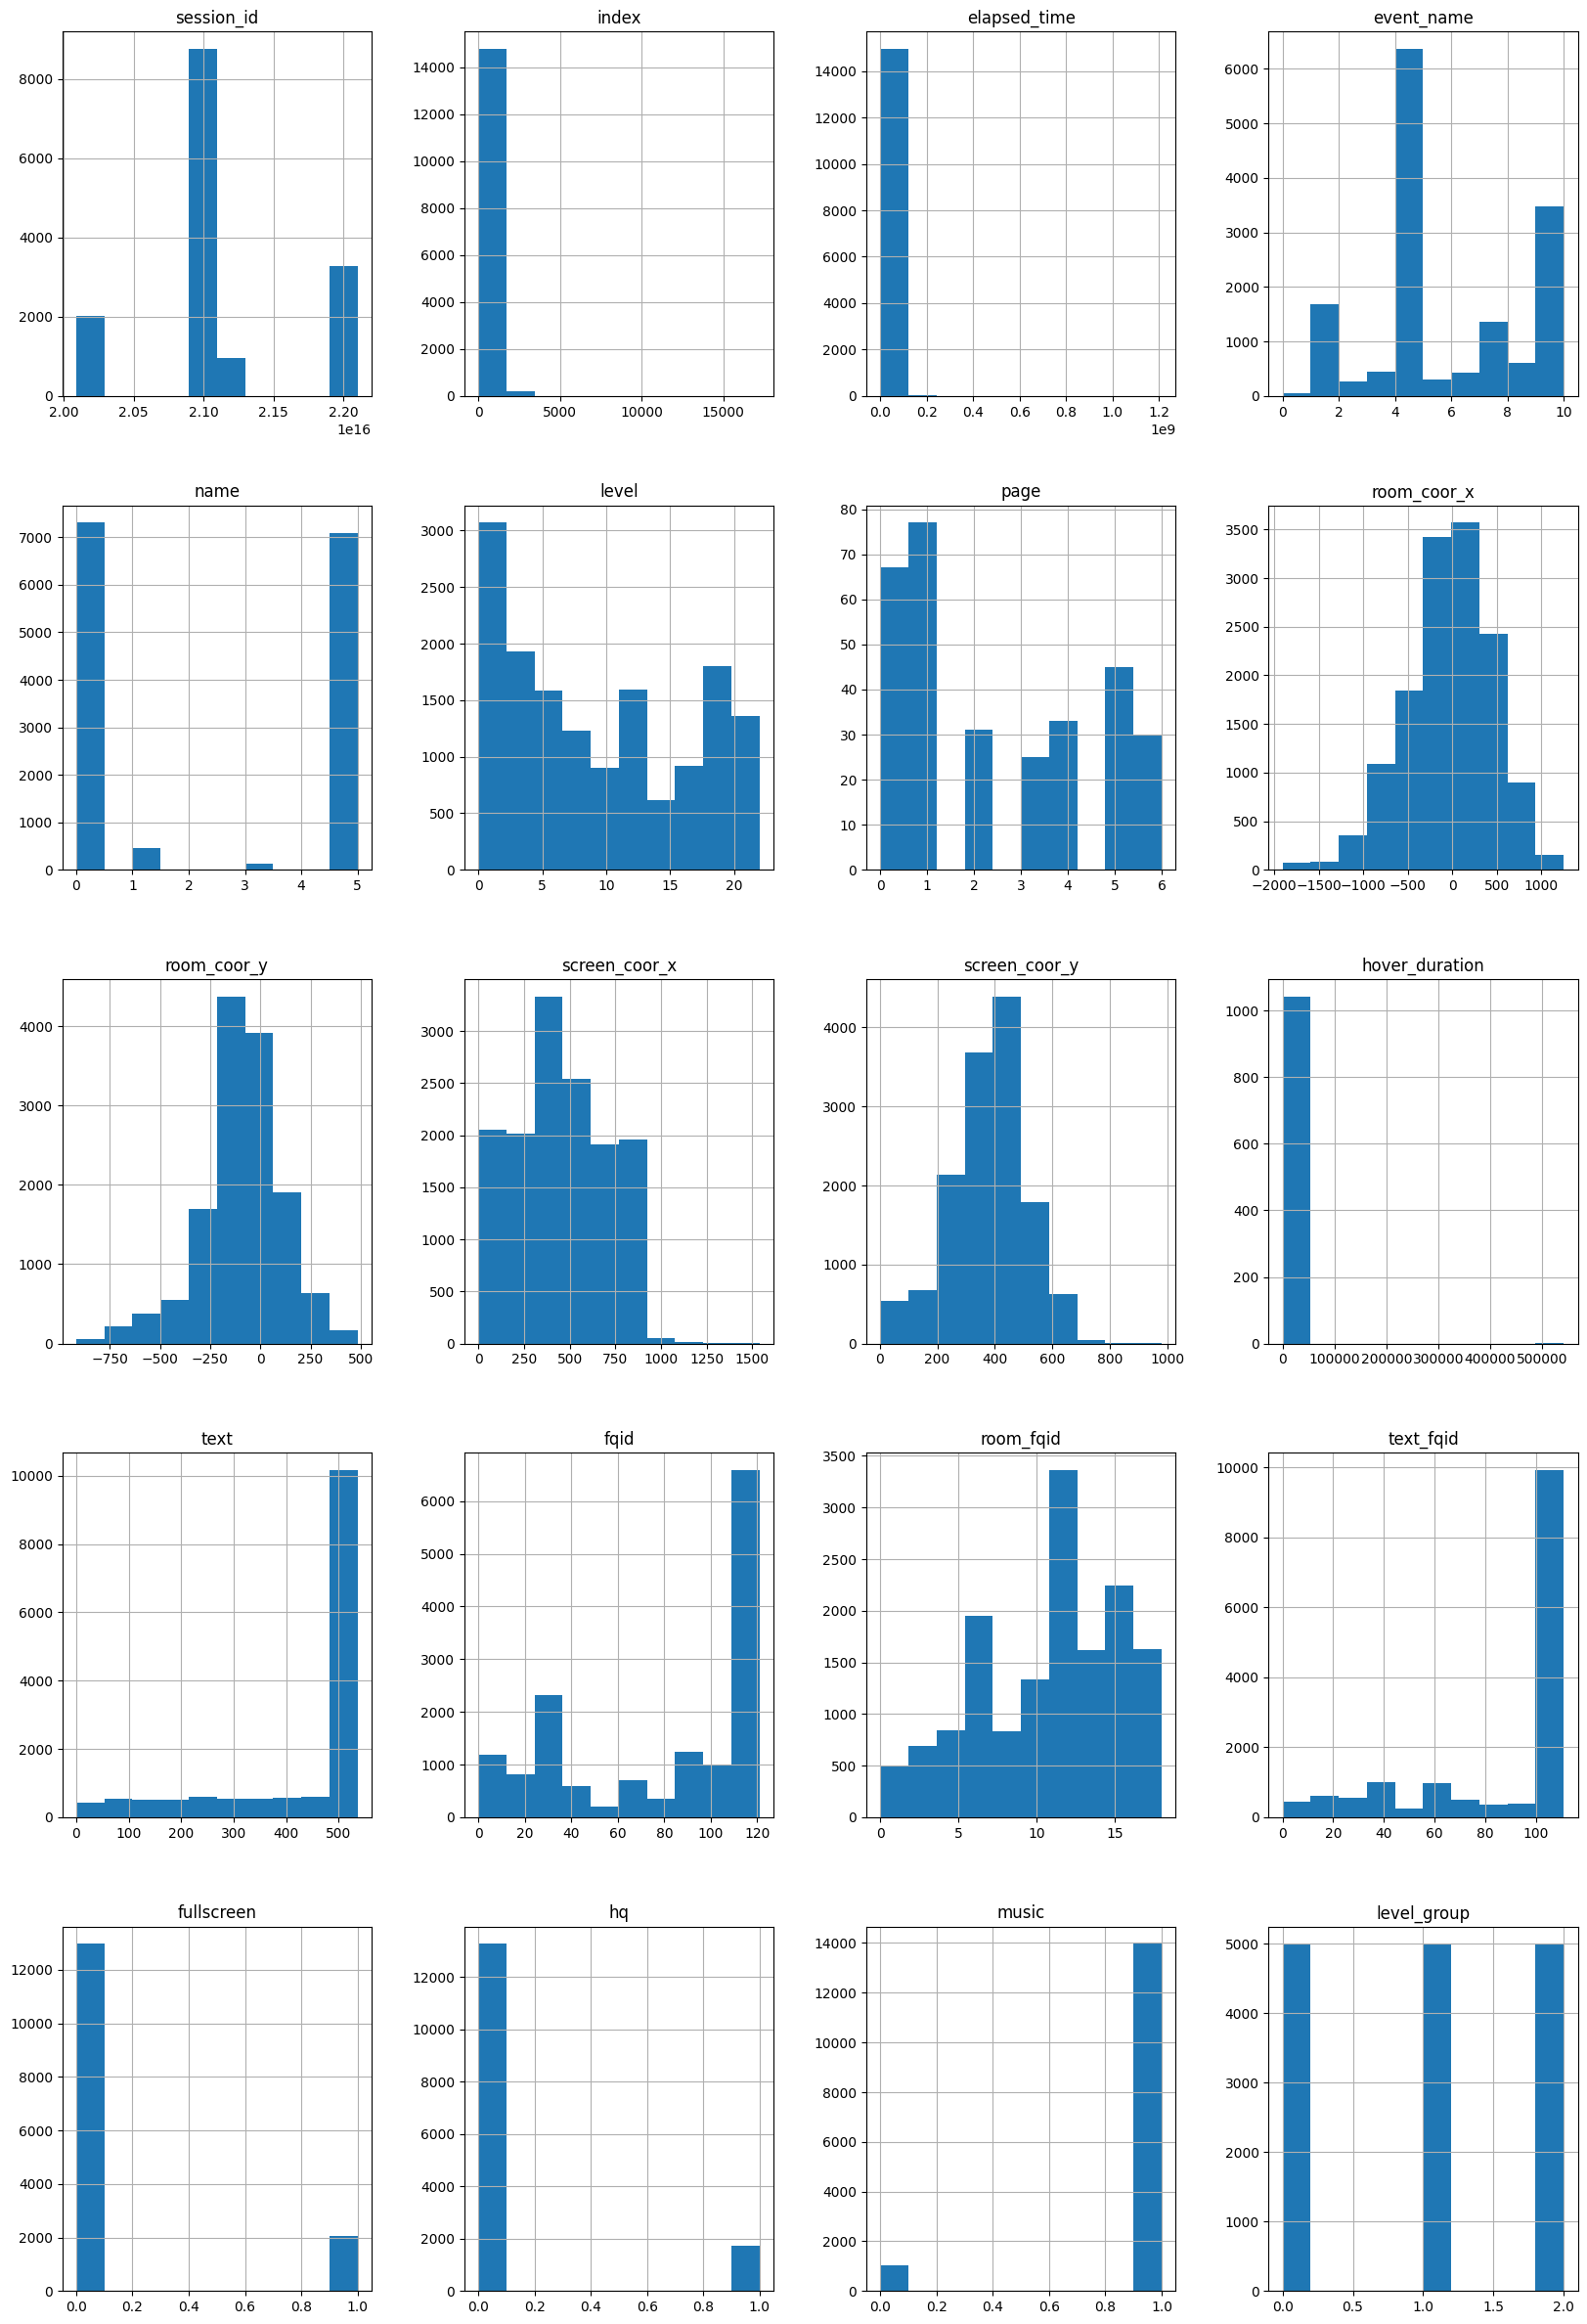

In [14]:
shown = strain[cols].hist(figsize=(20,30), layout=(5,4))

<Axes: >

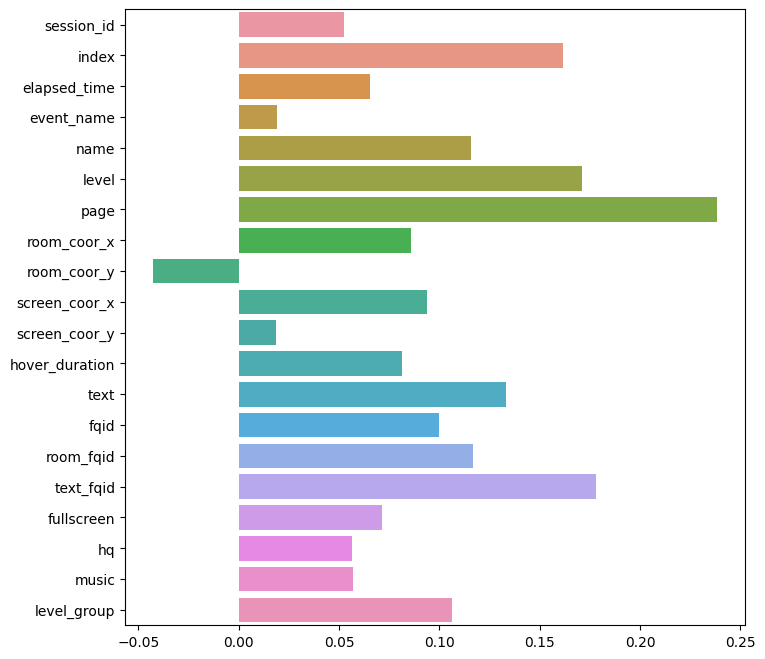

In [15]:
fig, ax = plt.subplots(figsize = (8,8))
corr = strain[cols].corr()
sns.barplot(data=corr,orient = 'h', errorbar = None)

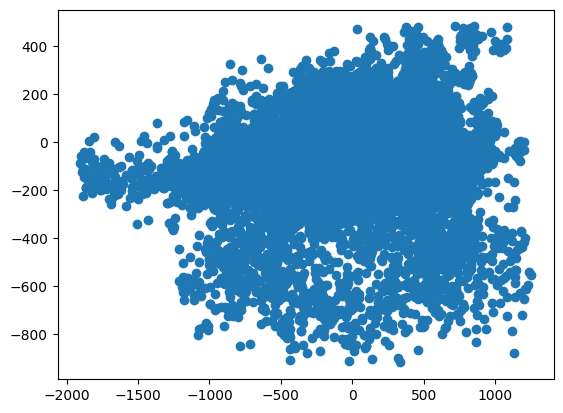

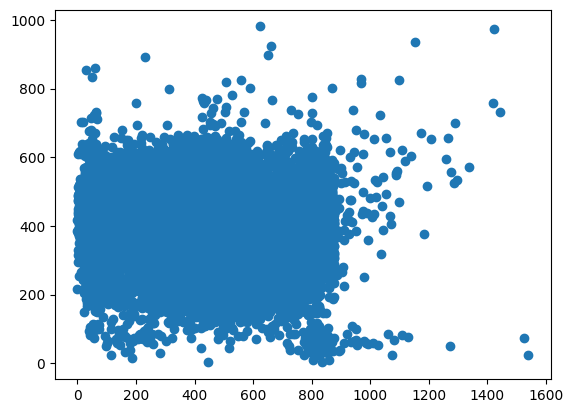

In [16]:
plt.scatter(strain['room_coor_x'], strain['room_coor_y'])
plt.show()

plt.scatter(strain['screen_coor_x'], strain['screen_coor_y'])
plt.show()

In [17]:
strain.isna().sum()

session_id            0
index                 0
elapsed_time          0
event_name            0
name                  0
level                 0
page              14692
room_coor_x        1099
room_coor_y        1099
screen_coor_x      1099
screen_coor_y      1099
hover_duration    13956
text                  0
fqid                  0
room_fqid             0
text_fqid             0
fullscreen            0
hq                    0
music                 0
level_group           0
dtype: int64

In [18]:
#fill NaN values

In [19]:
strain = strain[strain['level'] <= 18]
strain.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
3099366,20110416180353300,177,268574,4,5,4,NaN,-337.055182,-126.000000,51.0,456.0,NaN,536,121,15,111,0,0,1,0
21283926,22000509530558468,41,55680,1,0,1,NaN,431.266449,-171.235212,578.0,439.0,NaN,437,35,11,56,0,0,1,0
18625905,21090416203191896,129,171158,4,5,3,NaN,-261.968480,-73.000000,666.0,403.0,NaN,536,121,15,111,0,0,1,0
3834781,21000114353089548,120,220226,4,5,3,NaN,905.035985,-114.607953,780.0,400.0,NaN,536,97,11,111,0,1,1,0
808315,20100314121222052,64,118457,10,0,2,NaN,414.391836,131.453732,598.0,244.0,NaN,518,10,11,54,0,0,1,0


In [20]:
to_drop = ['page', 'hover_duration']
to_mean = ['fqid', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'text', 'text_fqid']

#hanlde na features(dropped)
for feature in to_drop:
    strain.drop(feature, axis=1, inplace=True)
    test.drop(feature, axis=1, inplace=True)

In [21]:
for feature in to_mean:
    t_mean = strain[feature].mean()
    st_mean = test[feature].mean()
    strain[feature] = strain[feature].fillna(t_mean)
    test[feature] = test[feature].fillna(st_mean)

In [22]:
#attach the targets to the right session_ids in the train set

In [23]:
merged = strain.merge(labels, on=['level','session_id'])

In [24]:
##try train test spilt feature here for accuracy test

In [25]:
y = merged['correct']
X = merged.drop(['correct'],axis=1)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [27]:
# feature selection

In [28]:
from sklearn.feature_selection import VarianceThreshold

print('Variance Threshold')

selvt = VarianceThreshold(threshold=1)
selvt = selvt.fit_transform(X_train)
selvt

Variance Threshold


array([[2.10404140e+16, 1.19400000e+03, 7.55308080e+07, ...,
        1.17000000e+02, 1.80000000e+01, 1.09000000e+02],
       [2.10402121e+16, 2.65000000e+02, 2.37118000e+05, ...,
        8.30000000e+01, 7.00000000e+00, 1.11000000e+02],
       [2.10503141e+16, 6.40000000e+02, 2.03211700e+06, ...,
        1.20000000e+02, 1.60000000e+01, 9.70000000e+01],
       ...,
       [2.20201111e+16, 2.22000000e+02, 3.34024000e+05, ...,
        0.00000000e+00, 1.20000000e+01, 6.20000000e+01],
       [2.10902176e+16, 7.80000000e+01, 4.73180000e+04, ...,
        9.10000000e+01, 1.10000000e+01, 1.11000000e+02],
       [2.10101096e+16, 3.42000000e+02, 3.09730000e+05, ...,
        6.00000000e+00, 1.20000000e+01, 7.10000000e+01]])

In [29]:
#accuracy scores from ben

In [32]:
HGBClf = HistGradientBoostingClassifier(max_bins=255, max_iter=100)
HGBClf.fit(X_train, y_train)
HGB_preds = HGBClf.predict(X_test)

#gives accuracy 0.6626506024096386 without tuning
SGDClf = linear_model.SGDClassifier(max_iter = 1000, tol=1e-3,penalty = "elasticnet")
SGDClf.fit(X_train, y_train)
SGD_preds = SGDClf.predict(X_test)

#gives accuracy 0.5542168674698795 without tuning
dtree = DecisionTreeClassifier(max_depth=10)
dtree.fit(X_train, y_train)
dtree_preds = dtree.predict(X_test)

#create grid search params for each model
HGBClf_params = {
    "max_iter": [50, 100, 200, 500, 1000],
    "max_bins": [50, 100, 200]
}

SGD_params = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "tol": [1e-3]
}

dtree_params = {
    "max_depth": [2, 5, 10, 100],
    "min_samples_split": [2, 4, 10, 20]
}

#perform grid search
GS = GridSearchCV(SGDClf, param_grid=SGD_params, scoring=["accuracy"], refit="accuracy", cv=5)
GS.fit(X_train, y_train)
GS_preds = GS.predict(X_test)

#show metrics
accuracy = accuracy_score(y_test, GS_preds)
f1 = f1_score(y_test, GS_preds)
print("\naccuracy: ")
print(accuracy)
print("\nf1: ")
print(f1)


accuracy: 
0.7542671362774316

f1: 
0.8599227799227799
